# NB. Linear Stability Analysis Using Orr-Sommerfeld Equation

> Philipp Schlatter and Saleh Rezaeiravesh <br />
  pschlatt@mech.kth.se and salehr@kth.se <br />
  SimEx/FLOW, KTH Engineering Mechanics, Royal Institute of Technology, Stockholm, Sweden

> This notebook is a part of the [KTH-Nek5000 lecture notes](https://kth-nek5000.github.io/kthNekBook/).


In [1]:
%matplotlib inline
import sys
import numpy as np
import scipy.linalg as scla
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math as mt
pi=mt.pi
import matplotlib.pylab as pylab
sys.path.append('./nbCodes/')
from chebdif import chebdif
params = {'legend.fontsize': 15,
          'legend.loc':'best',
          'figure.figsize': (8,6),
          'lines.markerfacecolor':'none',
          'axes.labelsize': 17,
          'axes.titlesize': 17,
          'xtick.labelsize':15,
          'ytick.labelsize':15,
          'grid.alpha':0.6}
pylab.rcParams.update(params)

## Orr-Sommerfeld equation

In this notebook, the two-dimensional Orr-Sommerfeld equation is numerically solved for the laminar channel flow. The differentiations are approximated by the Chebyshev method which is discussed in a separate notebook. 

The Orr-Sommerfeld equation for linear stability analysis can be derived as, 

$$
\begin{equation}
(U-c)(\hat{v}'' -\alpha^2 \hat{v})-\hat{v} U''=-\frac{i}{\alpha Re}(\hat{v}''''-2\alpha^2 \hat{v}'' +\alpha^4 \hat{v}) \,,
\end{equation}
$$

where $\hat{v}=\hat{v}(y)$, $U(y)$ is the velocity profile, $Re$ denotes Reynolds number, $\alpha$ is the wavenumber, and $c$ is the phase speed. 
All derivatives are with respect to the spatial coordinates $y$ where $y\in[-1,1]$. 
Introducing the differentiation operator $D$, where $\hat{v}^{(n)} = D^n \hat{v}$ leads to, 

$$
\begin{equation}
\underbrace{\left[ -\frac{1}{Re}\left(D^4-2\alpha^2 D^2+\alpha^4 I\right) -i \alpha U'' + i\alpha U (D^2-\alpha^2I)
\right]}_{A} \hat{v}
=
c\alpha\, \underbrace{i (D^2-\alpha^2 I)}_B \hat{v}
\end{equation}
$$

which can be written as, 

$$
\begin{equation}
A\hat{v} = \omega B\hat{v} \,,
\end{equation}
$$

where $\omega=c \alpha$. This equation defines a **generalized eigenvalue problem**. 

## Temporal stability analysis
For given $Re$ and $\alpha$, the Orr-Sommerfeld equation can be solved for the laminar channel flow with $U(y)=1-y^2$. As a result, the eigenvalues $c\in \mathbb{C}$ and associated eigenfunctions $\hat{v}(y)$ are computed. 

**Set the solution settings:**

In [16]:
Re = 6000      # Re_cl
alpha=1.0255   # streamwise wavenumber
N=200          # resolution

**Construct the differentiation operators:**
The differential opertors are approximated by the Chebyshev method. As described in the Chebyshev notebook, we use a generalized formualtion of Chebyshev differentiation matrix as applied in `chebdif.m`, see [Weideman and Reddy](https://web.iitd.ac.in/~mmehra/MATH4Q03/ft_gateway.cfm.pdf). A Python version of `chebdif.m` which is used here is taken from [dmsuite](https://github.com/ronojoy/pyddx/blob/master/sc/dmsuite.py), but small modifications have been applied. 

In [17]:
y,D_=chebdif(N,1)
D=D_[0,:,:]
D2=D@D
D4=D2@D2

**Construct the Orr-Sommerfeld operators A and B**

In [18]:
# A*vhat = omega*B*vhat
I = np.identity(N)
A = -(D4-2*D2*alpha**2+I*alpha**4)/Re + 2j*alpha*I + 1j*alpha*np.diag(1-y**2)@(D2-I*alpha**2)
B = 1j*(D2-I*alpha**2)

**Set the Boundary Conditions**

$$
\begin{equation}
\hat{v}(y=\pm 1) =0 \,,\quad\quad \hat{v}'(y=\pm 1) = 0
\end{equation}
$$

In [19]:
# move the eigenvalues of the BC to Q
Q=-999j
# two homogeneous Dirichlet conditions
A[0,:] = Q*I[0,:]
B[0,:] = I[0,:]
A[-1,:] = Q*I[-1,:]
B[-1,:] = I[-1,:]

In [20]:
# two homogeneous Neumann conditions
A[1,:] = Q*D[0,:]
B[1,:] = D[0,:]
A[-2,:] = Q*D[-1,:]
B[-2,:] = D[-1,:]

**Solve the eigenvalue problem**

In [21]:
# compute eigenvalues and eigenvectors (A*vhat = omega*B*vhat)
omega,vv = scla.eig(A,B)
c=omega/alpha

**Extract leading eigenvalue (TS wave)**

In [22]:
i=np.argmax(c.imag)
cmax = c[i]

v=vv[:,i]
u=-np.dot(D,v)/(1j*alpha)  # use continuity equation i alpha u + Dv = 0

print('Leading eigenvalue c = ',cmax)

Leading eigenvalue c =  (0.26279906996394214+0.0003429660987124634j)


**Scale eigenvectors**

In [14]:
i=np.argmax(abs(u))
w=u[i]
u/=w
v/=w

**Plot the spectrum (eigenvalues)**

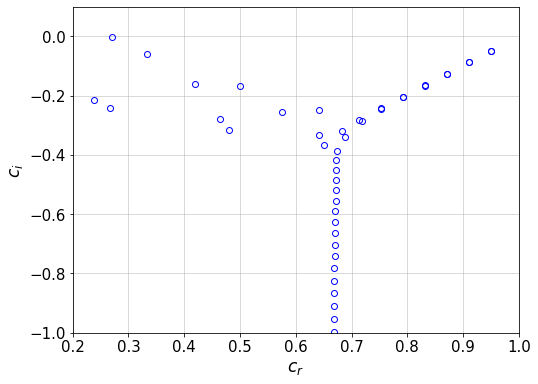

In [15]:
plt.figure()
plt.plot(c.real,c.imag,'ob')
plt.xlim([0.2,1])
plt.ylim([-1,0.1])
plt.grid()
plt.xlabel('$c_r$')
plt.ylabel('$c_i$')
plt.show()

**Plot amplitude of the perturbations**

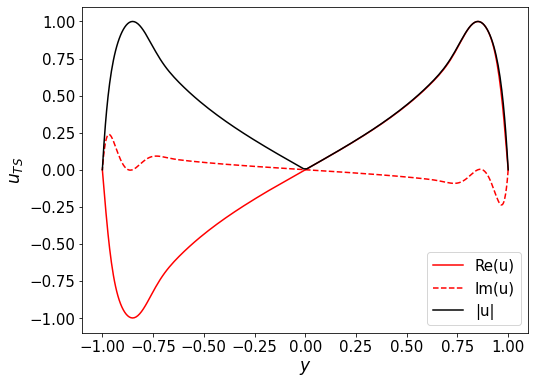

In [11]:
plt.figure()
plt.plot(y,u.real,'r',label='Re(u)')
plt.plot(y,u.imag,'r--',label='Im(u)')
plt.plot(y,abs(u),'k-',label='|u|')
plt.legend(loc='best')
plt.xlabel(r'$y$')
plt.ylabel(r'$u_{TS}$')
plt.show()

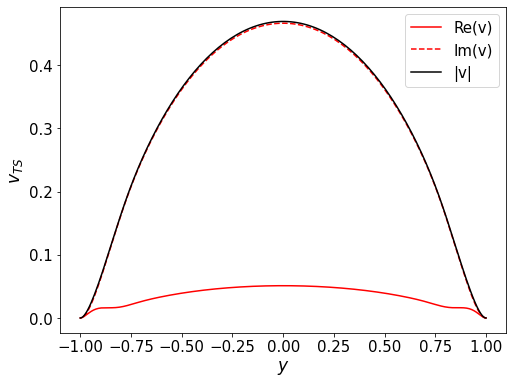

In [12]:
plt.figure()
plt.plot(y,v.real,'r',label='Re(v)')
plt.plot(y,v.imag,'r--',label='Im(v)')
plt.plot(y,abs(v),'k-',label='|v|')
plt.xlabel(r'$y$')
plt.ylabel(r'$v_{TS}$')
plt.legend(loc='best')
plt.show()

## Neutral stability curve for channel flow

The aim is to compute the contours of the maximum $imag(c)$ for given ranges of $Re$ and $\alpha$. Of particular interest is the isoline of $max(imag(c))=0$ which specifies the **neutral stability curve**.

**Create a mesh grid over the rectangular space of $Re\times \alpha$**

In [23]:
N_Re=21
N_alpha=20
RE,ALPHA = np.meshgrid(np.linspace(1000,40000,N_Re),np.linspace(0.5,1.2,N_alpha))

**Compute $max(imag(c))$ for any $(Re,\alpha)$ in the mesh**

In [24]:
g=np.zeros((N_alpha,N_Re))
for ii in range(N_Re):
    for jj in range(N_alpha):
        Re=RE[jj,ii]
        alpha=ALPHA[jj,ii]
        A = -(D4-2*D2*alpha**2+I*alpha**4)/Re + 2j*alpha*I + 1j*alpha*np.diag(1-y**2)@(D2-I*alpha**2)
        B = 1j*(D2-I*alpha**2)

        Q=-999j
        A[0,:] = Q*I[0,:]
        B[0,:] = I[0,:]
        A[-1,:]  = Q*I[-1,:]
        B[-1,:] = I[-1,:]
        A[1,:] = Q*D[0,:]
        B[1,:] = D[0,:]
        A[-2,:] = Q*D[-1,:]
        B[-2,:] = D[-1,:]
        
        omega,vv = scla.eig(A,B)
        g[jj,ii]=np.max(omega.imag)

**Plot the contours**

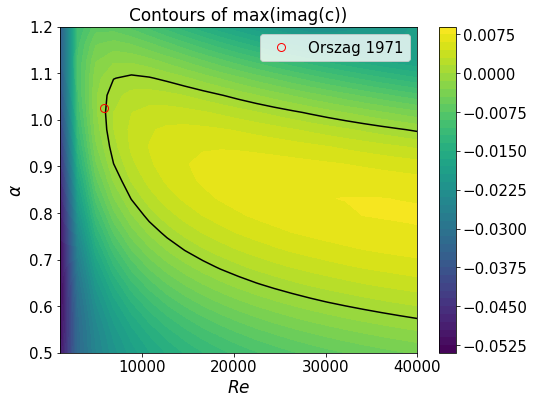

In [25]:
plt.figure()
CS=plt.contourf(RE[0,:],ALPHA[:,0],g,levels=40)
plt.colorbar()
CS1=plt.contour(RE[0,:],ALPHA[:,0],g,levels=[0],colors='k')
plt.title('Contours of max(imag(c))')
plt.xlabel(r'$Re$')
plt.ylabel(r'$\alpha$')
plt.plot(5772,1.0255,'ro',ms=8,label='Orszag 1971') # Orszag 1971
plt.legend()
plt.show()

In [10]:
omega

array([-6.43091296e+02-2.15315916e+03j, -6.44617231e+02-2.15247705e+03j,
        6.44620953e+02-2.15247455e+03j,  6.43094909e+02-2.15315669e+03j,
       -1.04624272e-11-9.99000000e+02j, -3.97947580e-10-9.99000000e+02j,
       -1.47221883e+01-5.50311552e+02j, -9.93434298e+00-5.50499156e+02j,
        1.47370813e+01-5.50278083e+02j,  9.94911655e+00-5.50449761e+02j,
        1.01088979e-02-2.55815021e+02j,  9.85884715e-03-2.55110553e+02j,
        2.43539175e-02-2.24008204e+02j,  2.39792680e-02-2.23455569e+02j,
        2.33643182e-02-1.41775432e+02j,  2.30803136e-02-1.41402215e+02j,
        3.85052843e-02-1.24893702e+02j,  3.80917160e-02-1.24602224e+02j,
        4.01903584e-02-8.97090863e+01j,  3.97882378e-02-8.94653611e+01j,
        5.71119305e-02-8.00886650e+01j,  5.65747341e-02-7.98954378e+01j,
        6.08598464e-02-6.19033135e+01j,  6.02877190e-02-6.17266766e+01j,
        7.97334220e-02-5.59658215e+01j,  7.90197533e-02-5.58232261e+01j,
        8.53713258e-02-4.53867769e+01j,  8.45782760